In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset, Subset
from tqdm import tqdm
from PIL import Image
import pickle
import models.optimizer.optimizer as optimizer
from torch.optim.lr_scheduler import ReduceLROnPlateau

# todo: select model here, uncomment to select the model
# from models import Alex_256_relu as m
# from models import Alex_256_sigmoid as m
# from models import Alex_256_tanh as m
from models import Alex_4096_relu as m
# from models import Alex_4096_tanh as m

from helper.training_early_stop import EarlyStop
import helper.utility as utility
import os

# 0. Data Pre-processing

In [88]:
size = (227, 227)
batch_size = 64

data_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # turn the graph to single color channel
    transforms.Resize(size), # resize to 227 * 227 because we use AlexNet
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485], std=[0.229])  # normalize
])

# data augmentation, increase sample size
data_transforms_R = utility.grayscale_transform_rotation(1, size, 90)
data_transforms_vf = utility.grayscale_transform_verticalflip(1, size, 1.0)
data_transforms_hf = utility.grayscale_transform_horizontalflip(1, size, 1.0)
data_transforms_crop = utility.grayscale_transform_crop(1, size, scale=(0.3, 1))

utility.create_augmentation_dataset('../dataset/train/', 'dataset1_disgust', 'disgust')

rotation = datasets.ImageFolder('../augmentation_dataset/dataset1_disgust/', transform=data_transforms_R)
vertical_flip = datasets.ImageFolder('../augmentation_dataset/dataset1_disgust/', transform=data_transforms_vf)
horizontal_flip = datasets.ImageFolder('../augmentation_dataset/dataset1_disgust/', transform=data_transforms_hf)
crop = datasets.ImageFolder('../augmentation_dataset/dataset1_disgust/', transform=data_transforms_crop)

train_dataset1 = datasets.ImageFolder('../dataset/train', transform=data_transforms)

train_dataset1 = ConcatDataset([train_dataset1, rotation, vertical_flip, horizontal_flip, crop])
torch.manual_seed(42)
train_size = int(0.85 * len(train_dataset1))
val_size = len(train_dataset1) - train_size
train_dataset1, val_dataset1 = random_split(train_dataset1, [train_size, val_size])
test_dataset1 = datasets.ImageFolder('../dataset/test', transform=data_transforms)

# train_dataset2 = datasets.ImageFolder('../dataset2_MMAFEDB/train', transform=data_transforms)
# train_dataset2_R = datasets.ImageFolder('../dataset2_MMAFEDB/train', transform=data_transforms_R)
# train_dataset2 = ConcatDataset([train_dataset2, train_dataset2_R])
# test_dataset2 = datasets.ImageFolder('../dataset2_MMAFEDB/test', transform=data_transforms)
# val_dataset2 = datasets.ImageFolder('../dataset2_MMAFEDB/valid', transform=data_transforms)

# train_loader = utility.combine_data(train_dataset1, train_dataset2, batch_size, True, True, 16)
# val_loader = utility.combine_data(val_dataset1, val_dataset2, batch_size, False, False, 16)
# test_loader = utility.combine_data(test_dataset1, test_dataset2, batch_size, False, False, 16)

train_loader = utility.imbalance_combine_data([train_dataset1], batch_size, pin_memory=True, num_workers=16)
val_loader = utility.imbalance_combine_data([val_dataset1], batch_size, pin_memory=True, num_workers=16)
test_loader = utility.imbalance_combine_data([test_dataset1], batch_size)

# check if the size of each label is balanced
print('Train label:')
train_label_count = utility.check_label_size(train_loader)
print('val label:')
val_label_count = utility.check_label_size(val_loader)
print('Test label:')
test_label_count = utility.check_label_size(test_loader)

# adjust the weight of each label
class_weights = utility.balance_weight(train_label_count, len(train_loader), batch_size)

criterion = nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights.values()))).to('cuda:0')
criterion = nn.CrossEntropyLoss()

data augmentation is already created at [../augmentation_dataset/dataset1_disgust/]
Train label:
Label 0: 3373 samples
Label 3: 6158 samples
Label 5: 4148 samples
Label 6: 2704 samples
Label 4: 4197 samples
Label 2: 3473 samples
Label 1: 1852 samples
val label:
Label 4: 772 samples
Label 3: 1061 samples
Label 6: 471 samples
Label 5: 686 samples
Label 0: 626 samples
Label 1: 328 samples
Label 2: 628 samples
Test label:
Label 0: 958 samples
Label 1: 111 samples
Label 2: 1024 samples
Label 3: 1774 samples
Label 4: 1233 samples
Label 5: 1247 samples
Label 6: 831 samples
adjusted weights: OrderedDict([(0, 1.0977934013807125), (3, 0.6013084025425695), (5, 0.8926849428295909), (6, 1.3693998309382924), (4, 0.8822628408046563), (2, 1.0661840319197071), (1, 1.9993829065103363)])


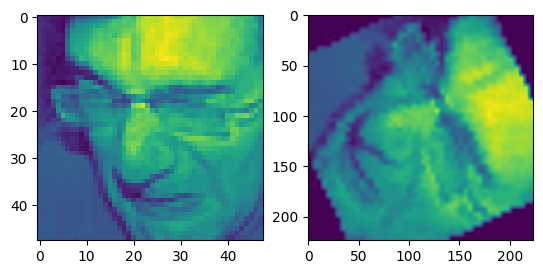

In [74]:
# check if transfromer is working
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
image = Image.open("../dataset/train/disgust/Training_11660541.jpg")
plt.subplot(1, 2, 1)
plt.imshow(image)
# Apply the transformations to the image
transformer = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomRotation((-90, 90)),
    transforms.Resize((224, 224)), 
])

plt.subplot(1, 2, 2)
transformed_image = transformer(image)

# Display the transformed image
plt.imshow(transformed_image)
plt.show()

In [77]:
# select device
device = utility.select_devices(use_cudnn_if_avaliable=True)

using CUDA + cudnn


# 1. Model

In [78]:
# average loss / epoch
loss_history_per_epoch = []
# correct prediction / epoch
correct_prediction_pre_epoch = []
# accuracy / epoch
accuracy_per_epoch = []
# validation loss
val_loss_per_epoch = []
# validation accuracy
val_accuracy_per_epoch = []

In [79]:
# todo: select optimizer
optimizer_name = "Adam"  # or "SGD"
# optimizer_name = "SGD"

# saving path
m.update_file_name(optimizer_name + "_dataset2")

# initialize model, loss-function and optimizer
model = m.EmotionCNN(num_classes=7)  # FER-2013 has 7 emotion class
if not os.path.exists(m.record_save_path):
    os.makedirs(m.record_save_path)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00001)
optimizer = optimizer.create_optimizer(model.parameters(), optimizer_name)

lr_scheduler = ReduceLROnPlateau(
            optimizer,
            mode='max',                 # 'max' for monitoring validation accuracy
            factor=0.4,                 # factor by which the learning rate will be reduced
            patience=5,                 # number of epochs with no improvement to trigger LR reduction
            min_lr=1e-7,                # minimum learning rate
            verbose=1                   # (1: print messages, 0: not print message)
        )

In [80]:
# training model
num_epochs = 2000

# early stopping variables
stop_counter = 10 # number of count to trigger early stop
stop_counter_window = 15 # a range to check stop_counter
different = 0.001 # different between the best val loss and the most recent one
stop_counter_interval = 30 # check for early stop for every stop_counter_interval
counter = 0 # number of count for every trail of early stop
is_always = True # always check for early stop, set to true will ignore other setting except stop_counter
is_exe = False # is early stop running
run_after =0
early_stopping = EarlyStop(m.pth_save_path, stop_counter, different, type="accuracy")

In [81]:
model.to(device)

# progress bar
process = tqdm(range(num_epochs), bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}', colour='green', unit='epoch')

for epoch in process:
    running_loss = 0.0
    accuracy = 0.0
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # forwarding get output
        outputs = model(inputs)
        # compute loss of output
        loss = criterion(outputs, labels)
        # backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # record training status
        running_loss += loss.item()
        prediction = outputs.argmax(dim=1)
        num_correct_prediction = (prediction == labels).sum().item()
        correct_prediction_pre_epoch.append(num_correct_prediction)
        accuracy += num_correct_prediction / inputs.shape[0]
    # save training status
    loss_history_per_epoch.append((running_loss / len(train_loader)))
    accuracy_per_epoch.append((accuracy / len(train_loader)))

    # training validation + early stopping
    if epoch >= run_after and (is_always or is_exe or epoch % stop_counter_interval == 0):
        val_loss = 0.0
        val_accuracy = 0.0

        if not is_always and epoch% stop_counter_interval ==0:
            early_stopping.counter = 0
            is_exe = True

        counter += 1

        if not is_always and counter >= stop_counter_window:
            counter = 0
            is_exe = False
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                prediction = outputs.argmax(dim=1)
                num_correct_prediction = (prediction == labels).sum().item()
                accuracy = num_correct_prediction / inputs.shape[0]
                val_accuracy += accuracy
        val_loss = val_loss / len(val_loader)
        val_accuracy = val_accuracy / len(val_loader)
        val_loss_per_epoch.append(val_loss)
        val_accuracy_per_epoch.append(val_accuracy)

        early_stopping.check_status(model, val_accuracy)

        # display recently 5 average loss of epochs
        process.set_description(f"loss= {'{:.5f}'.format(loss_history_per_epoch[-1])} - "
                                f"val loss= {'{:.5f}'.format(val_loss_per_epoch[-1])} - "
                                f"accuracy= {'{:.3%}'.format(accuracy_per_epoch[-1])} - "
                                f"val accuracy= {'{:.3%}'.format(val_accuracy_per_epoch[-1])} - "
                                f"best= {'{:.3%}'.format(early_stopping.best_of_all_value)} - "
                                f"Counter= {early_stopping.counter}/{stop_counter}")
    else:
        process.set_description(f"loss= {'{:.5f}'.format(loss_history_per_epoch[-1])} - "
                                f"accuracy= {'{:.3%}'.format(accuracy_per_epoch[-1])}")

    if early_stopping.early_stop:
        print('\nTrigger Early Stopping\n')
        early_stopping.early_stop = False
        break

loss= 0.08206 - val loss= 1.97612 - accuracy= 97.198% - val accuracy= 64.072% - best= 65.101% - Counter= 0/10:   3%|▌                   | 58/2000 [08:58<5:00:41,  9.29s/epoch]


Trigger Early Stopping



# 2. Save model and records

In [82]:
# save the pth file
torch.save(model.state_dict(), m.pth_manual_save_path)

utility.save_pickle_files(loss_history_per_epoch, m.record_save_path + '/loss_history.pkl')
utility.save_pickle_files(accuracy_per_epoch, m.record_save_path + '/accuracy_history.pkl')
utility.save_pickle_files(val_loss_per_epoch, m.record_save_path + '/val_loss_history.pkl')
utility.save_pickle_files(val_accuracy_per_epoch, m.record_save_path + '/val_accuracy_history.pkl')

# 3. Plot records and Evaluation

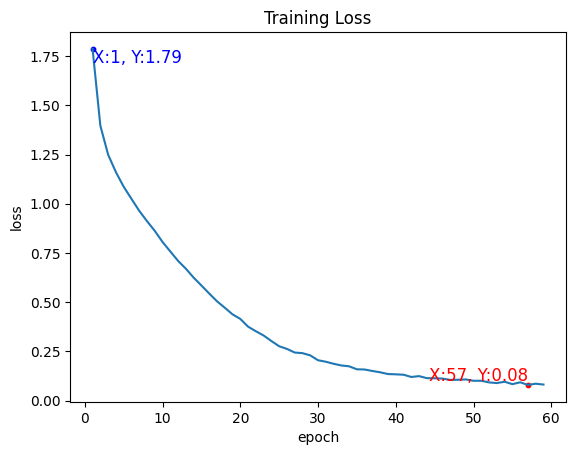

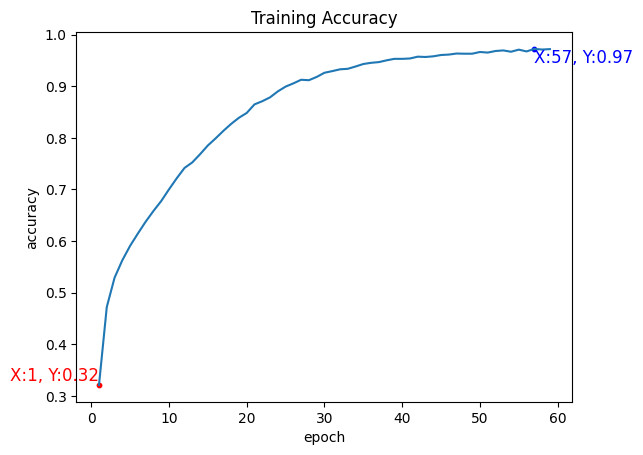

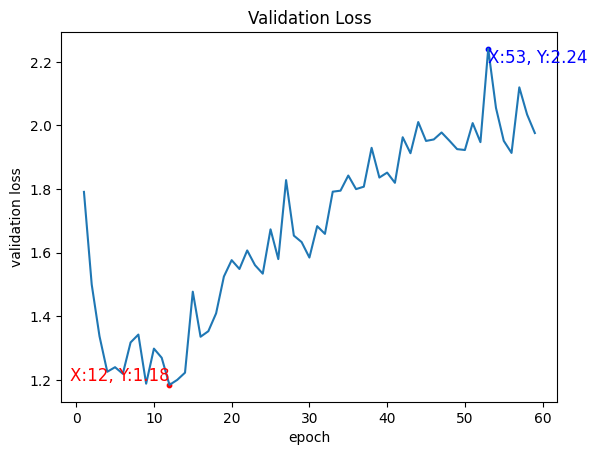

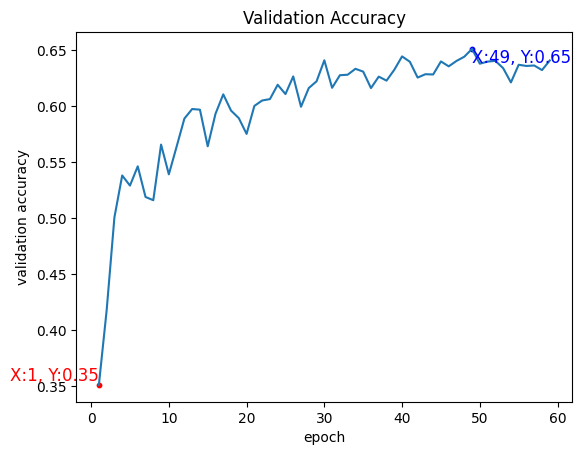

In [83]:
# draw graphs
data = utility.read_pickle_files(m.record_save_path + '/loss_history.pkl')
utility.plot_record(x=range(1, len(data)+1), y=data, xlabel="epoch", ylabel="loss", title="Training Loss", 
                    save_path=m.record_save_path+"/loss_history.png")

data = utility.read_pickle_files(m.record_save_path + '/accuracy_history.pkl')
utility.plot_record(x=range(1, len(data)+1), y=data, xlabel="epoch", ylabel="accuracy", title="Training Accuracy",
                    save_path=m.record_save_path+"/accuracy_history.png")

data = utility.read_pickle_files(m.record_save_path + '/val_loss_history.pkl')
utility.plot_record(x=range(run_after+1, run_after+len(data)+1), y=data, xlabel="epoch", ylabel="validation loss",
                    title="Validation Loss", save_path=m.record_save_path+"/val_loss_history.png")

data = utility.read_pickle_files(
    m.record_save_path + '/val_accuracy_history.pkl')
utility.plot_record(x=range(run_after+1, run_after+len(data)+1), y=data, xlabel="epoch", ylabel="validation accuracy",
                    title="Validation Accuracy", save_path=m.record_save_path+"/val_accuracy_history.png")


./model_data/Alex_4096_relu_Adam_dataset2/model.pth
Test Accuracy: 63.83393702981332%
              precision    recall  f1-score   support

           0       0.58      0.54      0.56       958
           1       0.55      0.70      0.62       111
           2       0.55      0.43      0.48      1024
           3       0.81      0.84      0.82      1774
           4       0.53      0.66      0.59      1233
           5       0.52      0.52      0.52      1247
           6       0.82      0.73      0.77       831

    accuracy                           0.64      7178
   macro avg       0.62      0.63      0.62      7178
weighted avg       0.64      0.64      0.64      7178

Test Accuracy: 62.69155753691836%
              precision    recall  f1-score   support

           0       0.48      0.63      0.54       958
           1       0.49      0.68      0.57       111
           2       0.52      0.48      0.50      1024
           3       0.82      0.83      0.82      1774
           4

<Figure size 700x700 with 0 Axes>

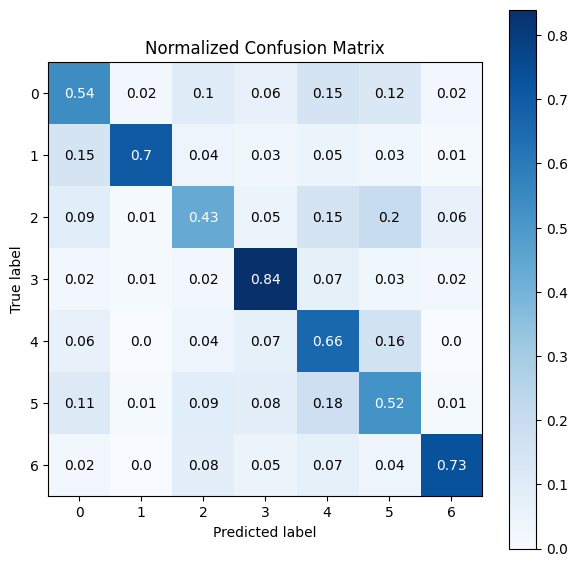

<Figure size 700x700 with 0 Axes>

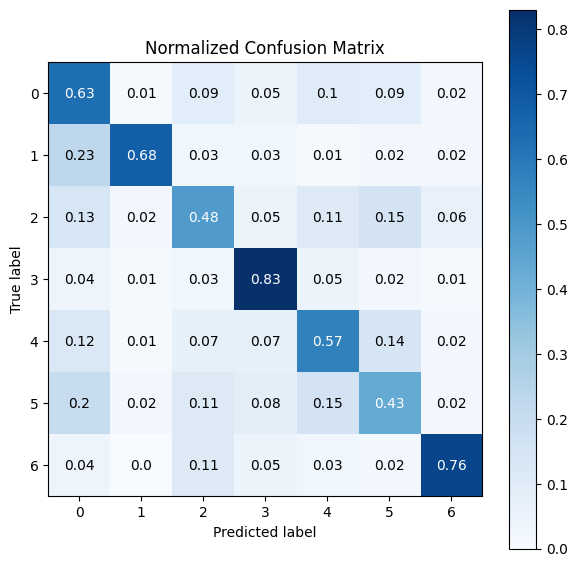

In [85]:
# evaluate model
model = m.EmotionCNN(num_classes=7)
print(m.pth_save_path)
utility.model_validation(model, device, test_loader, m.pth_save_path, m.record_save_path)
utility.model_validation(model, device, test_loader, m.pth_manual_save_path, m.record_save_path)